In [1]:
################
################   Clean Data + join Data + Generate Model + Evaluate
################   Telstra Network Disruptions Kaggle Competition
################

import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import grid_search
from scipy import stats

# import other methods
from clean import *


/usr/local/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
%matplotlib inline

In [3]:
# read the data
event = pd.read_csv("../../../github_data/telstradisr_data/event_type.csv")
log = pd.read_csv("../../../github_data/telstradisr_data/log_feature.csv")
sample = pd.read_csv("../../../github_data/telstradisr_data/sample_submission.csv")
severity = pd.read_csv("../../../github_data/telstradisr_data/severity_type.csv")
resource = pd.read_csv("../../../github_data/telstradisr_data/resource_type.csv")
train = pd.read_csv("../../../github_data/telstradisr_data/train.csv")
test = pd.read_csv("../../../github_data/telstradisr_data/test.csv")

In [4]:
# obtain integers out of strings with redundant data
event['event_type'] = event['event_type'].str.split(' ').str[1]
log['log_feature'] = log['log_feature'].str.split(' ').str[1]
severity['severity_type'] = severity['severity_type'].str.split(' ').str[1]
resource['resource_type'] = resource['resource_type'].str.split(' ').str[1]
test['location'] = test['location'].str.split(' ').str[1]
train['location'] = train['location'].str.split(' ').str[1]

In [5]:
# check in each log table if ids repeated
tables = [log,event,severity,resource] 
names = ['log','event','severity','resource'] 
for i in range(len(tables)):
    check = unique_column(tables[i],tables[i].columns[-1])
    
    # AGGREGATE CATEGORICAL VALUES INTO A DICTIO
    if check == False:
        if len(tables[i].columns) == 2:
            a = tables[i].groupby([tables[i].columns[-2],tables[i].columns[-1]]).agg({tables[i].columns[-1]:'count'})
            a.index.names = ['id','cat']
            a = a.reset_index()
            a = a.set_index('cat')
                    
            # take care that keys are still integers in the dict            
            a = a.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-1]].items()})
            tables[i] = pd.DataFrame(a,columns=[tables[i].columns[-1]])
            
        elif len(tables[i].columns) == 3:
            a = tables[i].groupby([tables[i].columns[-3],tables[i].columns[-2],tables[i].columns[-1]]).agg({tables[i].columns[-1]:'count',tables[i].columns[-2]:'count'})
            a.index.names = ['id','cat1','cat2']
            a = a.reset_index()
            a = a.set_index('cat1')
            b = a.set_index('cat2')
            
            # take care that keys are still integers in the dict
            a = a.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-1]].items()})
            b = b.groupby('id').apply(lambda x: {int(k):int(v) for k,v in x.to_dict()[tables[i].columns[-2]].items()})
            log1 = pd.DataFrame(a,columns=[tables[i].columns[-1]])
            log2 = pd.DataFrame(b,columns=[tables[i].columns[-2]])
event = tables[1]
severity = tables[2]
resource = tables[3]

In [6]:
# join tables with train data 
train = train.merge(event, left_on='id', right_index=True, how='left')
train = train.merge(severity, left_on='id', right_index=True, how='left')
train = train.merge(resource, left_on='id', right_index=True, how='left')
train = train.merge(log1, left_on='id', right_index=True, how='left')
train = train.merge(log2, left_on='id', right_index=True, how='left')

In [7]:
# join tables with test data
test = test.merge(event, left_on='id', right_index=True, how='left')
test = test.merge(severity, left_on='id', right_index=True, how='left')
test = test.merge(resource, left_on='id', right_index=True, how='left')
test = test.merge(log1, left_on='id', right_index=True, how='left')
test = test.merge(log2, left_on='id', right_index=True, how='left')

In [8]:
##### split data  
tr_a, te_a = train_test_split(train, train_size = 0.8)

## define variables 
y_train = tr_a.fault_severity
y_test = te_a.fault_severity
columns = train.columns
x_train = tr_a[columns[3:]]
x_test = te_a[columns[3:]]

In [ ]:
## define parameters
param_grid_1 =  {'randomforestclassifier__max_depth': [8,16],
               'randomforestclassifier__criterion': ['gini'], 
               'randomforestclassifier__n_estimators':[5,20], 
               'randomforestclassifier__max_leaf_nodes':[None], 
               'randomforestclassifier__min_samples_split':[2],
               'randomforestclassifier__min_samples_leaf':[10], 
               'randomforestclassifier__min_weight_fraction_leaf':[0.0],
               'randomforestclassifier__n_jobs':[1]
}

In [ ]:
##### generate pipeline 
## shape 5904x615
call = PipelineTelstra(RandomForestClassifier)
# check that the name of the attributes are the same as the parameter's name
gs = grid_search.GridSearchCV(call, param_grid_1, cv=2, n_jobs=2, pre_dispatch='n_jobs') # check scoring function
gs = gs.fit(x_train,y_train)

init event_type
init severity_type
init resource_type
init volume
init log_feature
pipeline done.
init event_type
init severity_type
init resource_type
init volume
init log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

init event_type
init severity_type
init resource_type
init volume
init log_feature
init event_type
init severity_type
init resource_type
init volume
init log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before event_type
DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after event_type
columns:  event_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit before severity_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after severity_type
columns:  severity_type
DataSpliterTrans transform done.
fit before resource_type
fit before event_type
DataSpliterTrans fit done.
DataSpliterTrans fit done.
fit after event_type
fit after resource_type
columns:  event_type
columns:  resource_type
DataSpliterTrans transform done.
DataSpliterTrans transform done.
fit before volume
DataSpliterTrans fit done.
fit after volume
fit before severity_type
columns:  volume
DataSpliterTrans fit done.
DataSpliterTrans transform done.
fit after severity_type
columns:  severity_type
DataSpliterTrans transform done.
fit before log_feature
fit before resource_type
DataSpliterTrans fit done.
DataSpliterTrans fit done.
fit after log_feature
fit after resource_type
columns:  log_feature
columns:  resource_type
DataSpliterTrans transform done.
DataSpliterTrans transform done.
fit before volume
DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  volume
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  event_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  severity_type
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  resource_type
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  volume
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  event_type
DataSpliterTrans transform done.
columns:  severity_type
columns:  log_feature
DataSpliterTrans transform done.
DataSpliterTrans transform done.
columns:  resource_type
DataSpliterTrans transform done.
columns:  volume
DataSpliterTrans transform done.
columns:  log_feature
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before event_type
DataSpliterTrans fit done.
fit after event_type
columns:  event_type
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before severity_type
DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

init event_type
init severity_type
init resource_type
init volume
init log_feature
init event_type
init severity_type
init resource_type
init volume
init log_feature
fit after severity_type
columns:  severity_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before event_type
fit before resource_type
DataSpliterTrans fit done.
DataSpliterTrans fit done.
fit after event_type
fit after resource_type
columns:  event_type
columns:  resource_type
DataSpliterTrans transform done.
DataSpliterTrans transform done.
fit before volume
DataSpliterTrans fit done.
fit after volume
fit before severity_type
columns:  volume
DataSpliterTrans transform done.
DataSpliterTrans fit done.
fit after severity_type
columns:  severity_type
DataSpliterTrans transform done.
fit before resource_type
fit before log_feature
DataSpliterTrans fit done.
DataSpliterTrans fit done.
fit after log_feature
fit after resource_type
columns:  log_feature
columns:  resource_type
DataSpliterTrans transform done.
DataSpliterTrans transform done.
fit before volume
DataSpliterTrans fit done.
fit after volume
columns:  volume
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after log_feature
columns:  log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  event_type
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  severity_type
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  resource_type
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  log_feature
DataSpliterTrans transform done.
columns:  event_type
DataSpliterTrans transform done.
columns:  severity_type
DataSpliterTrans transform done.
columns:  resource_type
DataSpliterTrans transform done.
columns:  volume
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before event_type
DataSpliterTrans transform done.
DataSpliterTrans fit done.
fit after event_type
columns:  event_type
fit before severity_type
DataSpliterTrans fit done.
fit after severity_type
columns:  severity_type
DataSpliterTrans transform done.
fit before resource_type
DataSpliterTrans fit done.
fit after resource_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  resource_type
init event_type
init severity_type
init resource_type
init volume
init log_feature
init event_type
init severity_type
init resource_type
init volume
init log_feature
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after volume
columns:  volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before event_type
DataSpliterTrans fit done.
fit after event_type
fit before log_feature
columns:  event_type
DataSpliterTrans fit done.
fit after log_feature
DataSpliterTrans transform done.
columns:  log_feature
DataSpliterTrans transform done.
fit before severity_type
DataSpliterTrans fit done.
fit after severity_type
columns:  severity_type
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit before resource_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after resource_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  resource_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before volume
DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.
columns:  event_type
DataSpliterTrans transform done.
fit before log_feature
DataSpliterTrans fit done.
fit after log_feature
columns:  log_feature
DataSpliterTrans transform done.
columns:  severity_type
DataSpliterTrans transform done.
columns:  resource_type
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  event_type
DataSpliterTrans transform done.
columns:  severity_type
DataSpliterTrans transform done.
DataSpliterTrans transform done.
columns:  resource_type
columns:  volume
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before event_type
DataSpliterTrans transform done.
DataSpliterTrans fit done.
fit after event_type
columns:  event_type
fit before severity_type
DataSpliterTrans fit done.
fit after severity_type
columns:  severity_type
DataSpliterTrans transform done.
fit before resource_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after resource_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  resource_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

init event_type
init severity_type
init resource_type
init volume
init log_feature
init event_type
init severity_type
init resource_type
init volume
init log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit before volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans fit done.
fit after volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.
fit before event_type
DataSpliterTrans fit done.
fit after event_type
columns:  event_type
DataSpliterTrans transform done.
fit before log_feature
DataSpliterTrans fit done.
fit after log_feature
columns:  log_feature
DataSpliterTrans transform done.
fit before severity_type
DataSpliterTrans fit done.
fit after severity_type
columns:  severity_type
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit before resource_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after resource_type
columns:  resource_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before volume
DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after volume


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  volume
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

fit before log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans fit done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


fit after log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


columns:  log_feature


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  event_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  severity_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  resource_type


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  volume
DataSpliterTrans transform done.


/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/usr/local/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspe

columns:  log_feature
columns:  event_type
DataSpliterTrans transform done.
DataSpliterTrans transform done.
columns:  severity_type
DataSpliterTrans transform done.
columns:  resource_type
DataSpliterTrans transform done.
columns:  volume
DataSpliterTrans transform done.
columns:  log_feature
DataSpliterTrans transform done.
init event_type
init severity_type
init resource_type
init volume
init log_feature
fit before event_type
DataSpliterTrans fit done.
fit after event_type
columns:  event_type
DataSpliterTrans transform done.
fit before severity_type
DataSpliterTrans fit done.
fit after severity_type
columns:  severity_type
DataSpliterTrans transform done.
fit before resource_type
DataSpliterTrans fit done.
fit after resource_type
columns:  resource_type
DataSpliterTrans transform done.
fit before volume
DataSpliterTrans fit done.
fit after volume
columns:  volume
DataSpliterTrans transform done.
fit before log_feature
DataSpliterTrans fit done.
fit after log_feature
columns:  log_f

In [13]:
##### plot the roc_auc to compare parameters
sco = gs.grid_scores_
sco

[mean: 0.67818, std: 0.01603, params: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_weight_fraction_leaf': 0.0, 'randomforestclassifier__n_jobs': 1, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 5},
 mean: 0.65837, std: 0.00073, params: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_weight_fraction_leaf': 0.0, 'randomforestclassifier__n_jobs': 1, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 20},
 mean: 0.67209, std: 0.00124, params: {'randomforestclassifier__max_depth': 16, 'randomforestclassifier__min_weight_fraction_leaf': 0.0, 'randomforestclassifier__n_jobs': 1, 'randomforest

In [14]:
# extract data from scoring function
meanv = np.zeros(len(sco))
deptv = np.zeros(len(sco),dtype=np.int)
estiv = np.zeros(len(sco),dtype=np.int)
deptk = [i for i in sco[0].parameters.keys()][0]
estik = [i for i in sco[0].parameters.keys()][7]

l = 0
while l < len(sco):
    mean = sco[l].mean_validation_score
    par = sco[l].parameters.values()
    values = [v for v in par]
    meanv[l] = mean
    estiv[l] = values[7]
    deptv[l] = values[0]
    l += 1

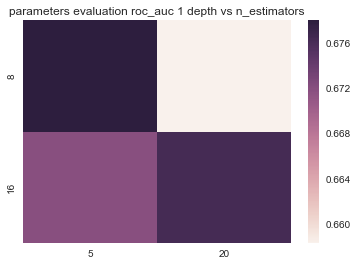

In [15]:
# plot scoring function data
ma = np.matrix([[meanv[0], meanv[1]], [meanv[2], meanv[3]]], dtype=np.float64)
scores = pd.DataFrame(ma,columns=np.unique(estiv),index=np.unique(deptv))
ax = sns.heatmap(scores)
ax.set_title('parameters evaluation roc_auc 1 depth vs n_estimators')
ax.set_title
fig = ax.get_figure()
fig.savefig("par_eval_1_depth8_10_esti20_100.png")

In [ ]:
##### generate y_predict
y_predict = call.predict(x_test)

In [ ]:
##### first evaluation confusion matrix
cm1 = confusion_matrix(y_test,y_predict)
cm1

In [ ]:
ax = sns.heatmap(cm1)
ax.set_title('confusion matrix 1')